In [109]:
# Import libraries

import os
import glob
from osgeo import gdal
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import scipy.ndimage
import pandas as pd
import datetime as dt
import rasterio as rio
import re
import geopandas as gpd
import earthpy as et
import earthpy.plot as ep
import earthpy.spatial as es
import earthpy.mask as em
from pyhdf.SD import SD, SDC
import pprint
import matplotlib.colors as colors 
from mpl_toolkits.axes_grid1 import make_axes_locatable 
import csv
import pprint
import h5py 

*** First bit is going to be the same as BA - then going to add NDVI data ***


In [110]:
# Set input directory, and change working directory - plug in D:
inDir = "D:\\masters_data\\MODIS_BA"   # I should change this so I can work from github?
os.chdir(inDir)                                                               # Change to working directory
outDir = os.path.normpath(os.path.split(inDir)[0] + os.sep + 'output') + '\\' # Create and set output directory
if not os.path.exists(outDir): os.makedirs(outDir)

In [111]:
# select first MODIS file
MODISFiles = glob.glob('*h20v07*') 
print(len(MODISFiles))
print(MODISFiles[0])

217
MCD64A1.A2002001.h20v07.006.2017012181506.hdf


In [112]:
# date range of tile
productId1 = MODISFiles[0].split('.')[0]                                          # First: product name
yeardoy1 = MODISFiles[0].split(productId1 + '.A')[1].split('.')[0]                 # Julian date
date1 = dt.datetime.strptime(yeardoy1, '%Y%j').strftime('%d/%m/%Y')                # Convert YYYYDDD to DD/MM/YYYY

productId2 = MODISFiles[-1].split('.')[0]                                         # First: product name
yeardoy2 = MODISFiles[-1].split(productId1 + '.A')[1].split('.')[0]                # Julian date
date2 = dt.datetime.strptime(yeardoy2, '%Y%j').strftime('%d/%m/%Y')                # Convert YYYYDDD to DD/MM/YYYY

print('First date of observation: {})'.format(date1))
print('Last date of observation:  {})'.format(date2))

First date of observation: 01/01/2002)
Last date of observation:  01/01/2020)


In [113]:
import gdal
from gdalconst import *
filename= MODISFiles[0]
dataset = gdal.Open(filename,GA_ReadOnly)
subdataset = dataset.GetSubDatasets()[1]

In [114]:
file_name = MODISFiles[0]
file = SD(file_name, SDC.READ)  # SDC means scientific dataset

# get data for Burn Date - can change this to get data for other simply by changing the index number
sds_obj = file.select(0) # select sds
data = sds_obj.get() # get sds data  

In [115]:
# create a new array
blanks = np.zeros((2400, 2400))
print(blanks.shape)

(2400, 2400)


In [116]:
NUMBER = 0

for j in MODISFiles:
    filename= MODISFiles[NUMBER]
    dataset = gdal.Open(filename,GA_ReadOnly)
    subdataset = dataset.GetSubDatasets()[1]
    
    with rio.open(MODISFiles[NUMBER]) as dataset:
        crs = dataset.read_crs()
    
    file_name = MODISFiles[NUMBER]
    file = SD(file_name, SDC.READ)   
    
    datasets_dic = file.datasets()
    sds_obj = file.select(0)
    data = sds_obj.get() 
    result = np.where(data > 0)
    
    blanks[result] += 1
    
    NUMBER += 1
    
print(blanks)



*** now time to add the NDVI data ***




In [118]:
# Set input directory, and change working directory - plug in D:
inDir = "D:\\masters_data\\MODIS_VI"   # I should change this so I can work from github?
os.chdir(inDir)
outDir = os.path.normpath(os.path.split(inDir)[0] + os.sep + 'output') + '\\' # Create and set output directory
if not os.path.exists(outDir): os.makedirs(outDir)

# select first MODIS file
VI_Files = glob.glob('*h20v07*') 
print(len(VI_Files))
print(VI_Files[0])

97
MOD13A1.A2007145.h20v07.006.2015161235732.hdf


In [119]:
# I want to see the date of MODIS_VI_FILES[0]

productId1 = VI_Files[0].split('.')[0]                                          # First: product name
yeardoy1 = VI_Files[0].split(productId1 + '.A')[1].split('.')[0]                 # Julian date
date1 = dt.datetime.strptime(yeardoy1, '%Y%j').strftime('%d/%m/%Y')                # Convert YYYYDDD to DD/MM/YYYY

print('date of observation: {}'.format(date1))

date of observation: 25/05/2007


In [121]:
datasets_dic = file.datasets()

for idx,sds in enumerate(datasets_dic.keys()):
    print(idx,sds)

0 Burn Date
1 Burn Date Uncertainty
2 QA
3 First Day
4 Last Day


In [122]:
file_name = VI_Files[0]
file = SD(file_name, SDC.READ)  # SDC means scientific dataset 
sds_obj = file.select(0) # select sds

VI_data = sds_obj.get() # get sds data
print(VI_data)
print(VI_data.shape)

[[ 986 1000 1043 ...  792  764  768]
 [1029 1036 1011 ...  785  777  784]
 [1039  992 1017 ...  781  769  772]
 ...
 [3406 3329 3321 ... 3942 3942 4532]
 [3331 3371 3587 ... 3683 3683 4425]
 [4002 4197 3874 ... 3665 3933 4109]]


### Low BA frequency

In [46]:
LF =  np.zeros((2400, 2400))
LF[LF == 0] = -9999

for i in blanks:
    LF_result = np.where(blanks == 0)
    LF[LF_result] = VI_data[LF_result]

    # the point of this code is to take the burned frequency array (blanks) and for every pixel which equals zero 
    # (low frequency), we take that index and match it to the index of the VI file (VI_data). The NDVI of this point
    # is then copied onto a blank array - LF
    
    # The issue: LF4 takes all values of VI_data not just the indexes

### moderate low BA frequency (1 - 3 years)

In [44]:
MLF = np.zeros((2400, 2400))
MLF[MLF == 0] = -9999

for i in blanks:
    MLF_result = np.where((blanks > 0) & (blanks < 3))
    MLF[MLF_result] = VI_data[MLF_result]

### Moderate High BA Frequency (3 - 10 times)

In [42]:
MHF = np.zeros((2400, 2400))   
MHF[MHF == 0] = -9999

for i in blanks:
    MHF_result = np.where((blanks > 2) & (blanks < 10))
    MHF[MHF_result] = VI_data[MHF_result]

###  High BA Frequency (10 times +)

In [28]:
HF = np.zeros((2400, 2400))       # high frequency (burned more than 10 times)
HF[HF == 0] = -9999

for i in blanks:
    HF_result = np.where(blanks > 9)
    HF[HF_result] = VI_data[HF_result]

In [50]:
print("LF min is: {} /n LF Max is {}".format(LF.min(), LF.max()))
print("MLF min is: {} /n MLF Max is {}".format(MLF.min(), MLF.max()))
print("MHF min is: {} /n MHF Max is {}".format(MHF.min(), MHF.max()))
print("HF min is: {} /n HF Max is {}".format(HF.min(), HF.max()))

# if u wanna save the LF file as an excel file, use code below

# np.savetxt("C:\\Users\\samgr\\OneDrive\\Desktop\\LF.csv", LF, delimiter=",")
# np.savetxt("C:\\Users\\samgr\\OneDrive\\Desktop\\MLF.csv", MLF, delimiter=",")
# np.savetxt("C:\\Users\\samgr\\OneDrive\\Desktop\\MHF.csv", MHF, delimiter=",")
# np.savetxt("C:\\Users\\samgr\\OneDrive\\Desktop\\HF.csv", HF, delimiter=",")

LF min is: -9999.0 /n LF Max is 7224.0
MLF min is: -9999.0 /n MLF Max is 6864.0
MHF min is: -9999.0 /n MHF Max is 7064.0
HF min is: -9999.0 /n HF Max is 7087.0


### now lets plot them all together

<ipython-input-58-59c8b8ee23ff>:11: MatplotlibDeprecationWarning: In a future version, 'pad' will default to rcParams['figure.subplot.wspace'].  Set pad=0 to keep the old behavior.
  cax = divider.append_axes("right", size ="5 %")


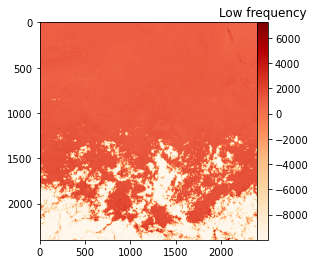

<ipython-input-58-59c8b8ee23ff>:29: MatplotlibDeprecationWarning: In a future version, 'pad' will default to rcParams['figure.subplot.wspace'].  Set pad=0 to keep the old behavior.
  cax = divider.append_axes("right", size ="5 %")


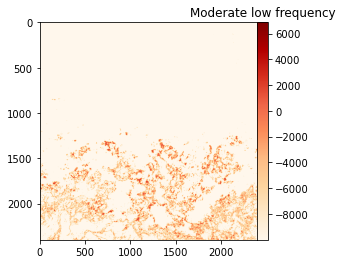

<ipython-input-58-59c8b8ee23ff>:50: MatplotlibDeprecationWarning: In a future version, 'pad' will default to rcParams['figure.subplot.wspace'].  Set pad=0 to keep the old behavior.
  cax = divider.append_axes("right", size ="5 %")


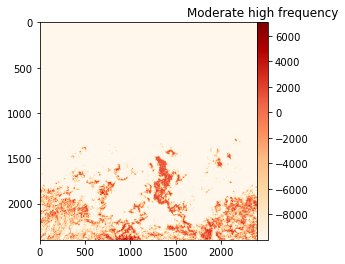

<ipython-input-58-59c8b8ee23ff>:69: MatplotlibDeprecationWarning: In a future version, 'pad' will default to rcParams['figure.subplot.wspace'].  Set pad=0 to keep the old behavior.
  cax = divider.append_axes("right", size ="5 %")


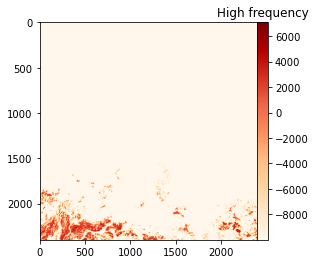

In [58]:
u = np.unique(VI_data) 
bounds = np.concatenate(([VI_data.min()], 
                         u[:-1]+np.diff(u)/2., 
                         [VI_data.max()])) 

fig, axes = plt.subplots() 
img = axes.imshow(VI_data, cmap = "PiYG", 
                  ) 
divider = make_axes_locatable(axes) 
cax = divider.append_axes("right", size ="5 %") 
  
color_bar = plt.colorbar(img,  
                        cax = cax) 

plt.title("Vegetation indices")  
plt.show() 

# display low frequency
u = np.unique(LF) 
bounds = np.concatenate(([LF.min()], 
                         u[:-1]+np.diff(u)/2., 
                         [LF.max()])) 
    
fig, axes = plt.subplots() 
img = axes.imshow(LF, cmap = "OrRd", 
                  ) 
divider = make_axes_locatable(axes) 
cax = divider.append_axes("right", size ="5 %") 
  
color_bar = plt.colorbar(img,  
                        cax = cax) 
plt.title("Low frequency")
plt.show() 


# show moderate low frequency
u = np.unique(MLF) 
bounds = np.concatenate(([MLF.min()], 
                         u[:-1]+np.diff(u)/2., 
                         [MLF.max()])) 
    
fig, axes = plt.subplots() 
img = axes.imshow(MLF, cmap = "OrRd", 
                  ) 
divider = make_axes_locatable(axes) 
cax = divider.append_axes("right", size ="5 %") 
  
color_bar = plt.colorbar(img,  
                        cax = cax) 
plt.title("Moderate low frequency")
plt.show()




# show moderate High frequency

u = np.unique(MHF) 
bounds = np.concatenate(([MHF.min()], 
                         u[:-1]+np.diff(u)/2., 
                         [MHF.max()])) 
    
fig, axes = plt.subplots() 
img = axes.imshow(MHF, cmap = "OrRd", 
                  ) 
divider = make_axes_locatable(axes) 
cax = divider.append_axes("right", size ="5 %") 
  
color_bar = plt.colorbar(img,  
                        cax = cax) 
plt.title("Moderate high frequency") 
plt.show() 



# show high frequency
u = np.unique(HF) 
bounds = np.concatenate(([HF.min()], 
                         u[:-1]+np.diff(u)/2., 
                         [HF.max()])) 
    
fig, axes = plt.subplots() 
img = axes.imshow(HF, cmap = "OrRd", 
                  ) 
divider = make_axes_locatable(axes) 
cax = divider.append_axes("right", size ="5 %") 
  
color_bar = plt.colorbar(img,  
                        cax = cax) 
plt.title("High frequency")
plt.show() 

In [75]:
# now can start to calculate means etc... 
HF_result = np.where(HF > -9999)
print(HF_result)

(array([1384, 1395, 1395, ..., 2399, 2399, 2399], dtype=int64), array([ 495,  495,  497, ..., 2389, 2390, 2391], dtype=int64))


TO DO LIST:

Plot these as subplots
    - not sure how with more complex plots

for loop through MODIS_VI files (correct tile) and add all values to blan array. Then divide all by number of MODIS files so that we get an average VI_file.
    This can later be easily changed to show average for each year.
          